# RealEstate regression in Budapest

In [1]:
# Import all necessery python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import requests as req
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import time
import seaborn as sns

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV, Ridge, lars_path
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

from IPython.display import Image

import pickle

import folium

import geojson

import geopy
import geopy.distance

from IPython.display import display

from tqdm import tqdm

# Load data

In [2]:
def loadpickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [174]:
raw_data = loadpickle('./data/dataframe.pkl')

# Preprocessing

In [4]:
df_work = raw_data.copy()

## Add data

In [5]:
def extendColumnWithData(id):
    page = loadpickle('./data/details/'+ id + '.pkl')
    soup_ingatlan = BeautifulSoup(page.content,"lxml")
    subtype = soup_ingatlan.find('div', {'class':'listing-subtype'}).text
    description = soup_ingatlan.find('div', {'class':'long-description'}).text
    df.loc[df['ID']==id, 'SUBTYPE'] = subtype
    df.loc[df['ID']==id, 'DESCRIPTION'] = description

In [6]:
raw_data['SUBTYPE'].unique()

array(['Eladó tégla építésű lakás', 'Eladó panel lakás',
       'Tégla építésű lakás bérleti joga átadó',
       'Új építésű lakás lakóparkban', 'Eladó csúszózsalus lakás',
       'Panel lakás bérleti joga átadó'], dtype=object)

In [7]:
raw_data.head()

,ID,SIZE,PRICE,ROOMS,FLOOR,ADDRESS,QUALITY,YEAR_BUILT,FLOORS_IN_BUILDING,LIFT,Balcony,ORIENTATION,VIEW,METRO_NEARBY,PARKING,DISTRICT,LATITUDE,LONGITUDE,SUBTYPE,DESCRIPTION
0,23545892,39 m²,"31,9 millió Ft",1,földszint,"7. kerület, Dob utca 50.",közepes állapotú,1950 előtt,2,nincs megadva,NaN,dél,utcai,False,"utca, közterület - fizetős övezet",7,47.501126,19.065041,Eladó tégla építésű lakás,"A VII. ker. Dob utcában, a körúton belül, egy..."
1,23652121,79 m²,"65,9 millió Ft",3,4,"6. kerület, Belső-Terézváros",felújított,1950 előtt,nincs megadva,nincs megadva,NaN,nincs megadva,nincs megadva,False,nincs megadva,6,47.509494,19.065323,Eladó tégla építésű lakás,"VI. ker. Zichy Jenő utcában eladó, egy 79 nm-..."
2,23662271,75 m²,89 millió Ft,2 + 1 fél,1,"7. kerület, Belső-Erzsébetváros",újszerű,1950 előtt,4,van,NaN,délnyugat,utcai,False,nincs megadva,7,47.502627,19.077243,Eladó tégla építésű lakás,"Belváros forgatagában, a Zsinagóga közelében,..."
3,23662566,50 m²,"22,9 millió Ft",2,4,"3. kerület, Bécsi út",felújítandó,1950-1980 között,10,van,NaN,nyugat,utcai,False,"utca, közterület - fizetős övezet",3,47.532673,19.036491,Eladó panel lakás,"Óbuda lakótelepen, a Bécsi úton 2 szobás laká..."
4,23688806,32 m²,"12,5 millió Ft",1,3,"9. kerület, Haller utca",jó állapotú,NaN,3,nincs,NaN,nincs megadva,nincs megadva,False,"utca, közterület",9,47.476099,19.077198,Tégla építésű lakás bérleti joga átadó,"Budapest , IX. kerületi 32 nm-es ,galériázott..."


## Check position

The maximum distance from the center of Budapest cannot be more than 30km so we need to filter this 

In [8]:
outliers = list()
for i in tqdm(raw_data['ID']):
    coord = geopy.Point(raw_data[raw_data['ID']==i][['LATITUDE', 'LONGITUDE']].to_numpy())
    meter = geopy.distance.distance(coord, (47.497913,19.040236)).m
    if(meter > 30000):
        outliers.append(i)

100%|███████████████████████████████████████████████████████████████████████████| 18561/18561 [00:37<00:00, 492.54it/s]


In [9]:
raw_data[raw_data['ID'].isin(outliers)]

,ID,SIZE,PRICE,ROOMS,FLOOR,ADDRESS,QUALITY,YEAR_BUILT,FLOORS_IN_BUILDING,LIFT,Balcony,ORIENTATION,VIEW,METRO_NEARBY,PARKING,DISTRICT,LATITUDE,LONGITUDE,SUBTYPE,DESCRIPTION
817,28286033,160 m²,"149,6 millió Ft",4,8,"8. kerület, LEO 50",új építésű,2019,8,van,69.68 m²,nincs megadva,panorámás,False,teremgarázs hely - megvásárolható,8,50.353042,13.905543,Új építésű lakás lakóparkban,
5595,30365960,38 m²,"34,8 millió Ft",2,1,"13. kerület, UpTown",új építésű,2021,nincs megadva,van,6.92 m²,nincs megadva,nincs megadva,False,teremgarázs hely - megvásárolható,13,48.179869,17.114408,Új építésű lakás lakóparkban,ÚJ ÉPÍTÉSŰ TÁRSASHÁZ MEGÚJULÓ ENERGIAFORRÁSSA...
5596,30366029,39 m²,"35,43 millió Ft",2,1,"13. kerület, UpTown",új építésű,2021,nincs megadva,van,7.57 m²,nincs megadva,nincs megadva,False,teremgarázs hely - megvásárolható,13,48.179869,17.114408,Új építésű lakás lakóparkban,ÚJ ÉPÍTÉSŰ TÁRSASHÁZ MEGÚJULÓ ENERGIAFORRÁSSA...
5597,30366032,40 m²,"36,86 millió Ft",2,1,"13. kerület, UpTown",új építésű,2021,nincs megadva,van,13.52 m²,nincs megadva,nincs megadva,False,teremgarázs hely - megvásárolható,13,48.179869,17.114408,Új építésű lakás lakóparkban,ÚJ ÉPÍTÉSŰ TÁRSASHÁZ MEGÚJULÓ ENERGIAFORRÁSSA...
5598,30366038,54 m²,"48,1 millió Ft",2,1,"13. kerület, UpTown",új építésű,2020,nincs megadva,van,13.16 m²,nincs megadva,nincs megadva,False,teremgarázs hely - megvásárolható,13,48.179869,17.114408,Új építésű lakás lakóparkban,ÚJ ÉPÍTÉSŰ TÁRSASHÁZ MEGÚJULÓ ENERGIAFORRÁSSA...
5599,30366044,48 m²,"43,44 millió Ft",2,1,"13. kerület, UpTown",új építésű,2021,nincs megadva,van,8.68 m²,nincs megadva,nincs megadva,False,teremgarázs hely - megvásárolható,13,48.179869,17.114408,Új építésű lakás lakóparkban,ÚJ ÉPÍTÉSŰ TÁRSASHÁZ MEGÚJULÓ ENERGIAFORRÁSSA...
5600,30366047,68 m²,60 millió Ft,3,1,"13. kerület, UpTown",új építésű,2021,nincs megadva,van,11.5 m²,nincs megadva,nincs megadva,False,teremgarázs hely - megvásárolható,13,48.179869,17.114408,Új építésű lakás lakóparkban,ÚJ ÉPÍTÉSŰ TÁRSASHÁZ MEGÚJULÓ ENERGIAFORRÁSSA...
5723,30389044,75 m²,"63,3 millió Ft",3,2,"13. kerület, UpTown",új építésű,2021,nincs megadva,van,4.81 m²,nincs megadva,nincs megadva,False,teremgarázs hely - megvásárolható,13,48.179869,17.114408,Új építésű lakás lakóparkban,ÚJ ÉPÍTÉSŰ TÁRSASHÁZ MEGÚJULÓ ENERGIAFORRÁSSA...
5724,30389056,39 m²,"35,85 millió Ft",2,2,"13. kerület, UpTown",új építésű,2021,nincs megadva,van,7.57 m²,nincs megadva,nincs megadva,False,teremgarázs hely - megvásárolható,13,48.179869,17.114408,Új építésű lakás lakóparkban,ÚJ ÉPÍTÉSŰ TÁRSASHÁZ MEGÚJULÓ ENERGIAFORRÁSSA...
5725,30389059,39 m²,"35,85 millió Ft",2,2,"13. kerület, UpTown",új építésű,2021,nincs megadva,van,7.57 m²,nincs megadva,nincs megadva,False,teremgarázs hely - megvásárolható,13,48.179869,17.114408,Új építésű lakás lakóparkban,ÚJ ÉPÍTÉSŰ TÁRSASHÁZ MEGÚJULÓ ENERGIAFORRÁSSA...


In [46]:
df_work.loc[df_work['ADDRESS'] == "8. kerület, LEO 50", 'LATITUDE'] = 47.483932
df_work.loc[df_work['ADDRESS'] == "8. kerület, LEO 50", 'LONGITUDE'] = 19.0750904
df_work.loc[df_work['ADDRESS'] == "13. kerület, UpTown", 'LATITUDE'] = 47.537934
df_work.loc[df_work['ADDRESS'] == "13. kerület, UpTown", 'LONGITUDE'] = 19.083626
df_work.loc[df_work['ADDRESS'] == "8. kerület, H5 Residence", 'LATITUDE'] = 47.4934018
df_work.loc[df_work['ADDRESS'] == "8. kerület, H5 Residence", 'LONGITUDE'] = 19.0800269

### Standardizing size

In [11]:
df_work['SIZE'] = raw_data['SIZE'].str[:-3].str.replace(" ","").astype('int')

In [177]:
df_work['Balcony'] = raw_data['Balcony'].str[:-3].str.replace(" ","").fillna(0).astype('float')


### Standardizing price
to million forint

In [12]:
milliard_df = raw_data[(raw_data['PRICE'].str.endswith('milliárd Ft', na=False))]
millio_df = raw_data[(raw_data['PRICE'].str.endswith('millió Ft', na=False))]

In [13]:
df_work.loc[raw_data['PRICE'].str.endswith('milliárd Ft', na=False), 'PRICE'] = milliard_df['PRICE'].str.split().str[0].str.replace(',', '.').astype('float') * 1000
df_work.loc[raw_data['PRICE'].str.endswith('millió Ft', na=False), 'PRICE'] = millio_df['PRICE'].str.split().str[0].str.replace(',', '.').astype('float')

### Convert room and half room numbers

In [14]:
df_work['rooms'] = df_work['ROOMS']
df_work['half_rooms'] = 0

In [15]:
df_work[['rooms', 'half_rooms']] = df_work['ROOMS'].str[:-4].str.replace(" ","").str.split('\+',expand=True)

In [16]:
df_work.loc[~(df_work['ROOMS'].str.contains('fél', na=False)), 'rooms'] = df_work[~(df_work['ROOMS'].str.contains('\+', na=False))]['ROOMS']

In [17]:
df_work['half_rooms'].fillna(value=0, inplace=True)

In [18]:
df_work['rooms'] = df_work['rooms'].str.replace(" ","").astype('int')

In [19]:
df_work[(df_work['ROOMS'].str.contains('\+', na=False))][['ROOMS', 'rooms', 'half_rooms']]

,ROOMS,rooms,half_rooms
2,2 + 1 fél,2,1
8,3 + 1 fél,3,1
16,1 + 2 fél,1,2
21,1 + 1 fél,1,1
32,2 + 1 fél,2,1
...,...,...,...
18547,2 + 1 fél,2,1
18554,1 + 1 fél,1,1
18555,4 + 1 fél,4,1
18557,1 + 3 fél,1,3


### Convert floors to number

In [20]:
raw_data['FLOOR'].unique()

array(['földszint', '4', '1', '3', 'nincs megadva', '2', '5', '7', '8',
       'félemelet', 'szuterén', '6', '9', '10', '10 felett'], dtype=object)

In [21]:
df_work.loc[(raw_data['FLOOR']=='földszint'), 'FLOOR'] = 0
df_work.loc[(raw_data['FLOOR']=='félemelet'), 'FLOOR'] = 1
df_work.loc[(raw_data['FLOOR']=='szuterén'), 'FLOOR'] = -1
df_work.loc[(raw_data['FLOOR']=='10 felett'), 'FLOOR'] = 11
df_work.loc[(raw_data['FLOOR']=='nincs megadva'), 'FLOOR'] = 0
df_work['FLOOR'] = df_work['FLOOR'].astype('int')

### Checking quality

In [22]:
raw_data['QUALITY'].unique() 

array(['közepes állapotú', 'felújított', 'újszerű', 'felújítandó',
       'jó állapotú', 'új építésű', 'nincs megadva', 'befejezetlen'],
      dtype=object)

### Checking built year

In [23]:
raw_data['YEAR_BUILT'].unique() 

array(['1950 előtt', '1950-1980 között', nan, '2019', '2017', '2020',
       '2001-2010 között', '2015', '2018', '2012', '1981-2000 között',
       '2021', '2011', '2016', '2022', '2013', '2014'], dtype=object)

### Add price per meter

In [24]:
df_work['PRICE_PER_METER'] = df_work['PRICE'] / df_work['SIZE']

In [25]:
df_work.head(20)

,ID,SIZE,PRICE,ROOMS,FLOOR,ADDRESS,QUALITY,YEAR_BUILT,FLOORS_IN_BUILDING,LIFT,...,METRO_NEARBY,PARKING,DISTRICT,LATITUDE,LONGITUDE,SUBTYPE,DESCRIPTION,rooms,half_rooms,PRICE_PER_METER
0,23545892,39,31.9,1,0,"7. kerület, Dob utca 50.",közepes állapotú,1950 előtt,2,nincs megadva,...,False,"utca, közterület - fizetős övezet",7,47.501126,19.065041,Eladó tégla építésű lakás,"A VII. ker. Dob utcában, a körúton belül, egy...",1,0,0.817949
1,23652121,79,65.9,3,4,"6. kerület, Belső-Terézváros",felújított,1950 előtt,nincs megadva,nincs megadva,...,False,nincs megadva,6,47.509494,19.065323,Eladó tégla építésű lakás,"VI. ker. Zichy Jenő utcában eladó, egy 79 nm-...",3,0,0.834177
2,23662271,75,89,2 + 1 fél,1,"7. kerület, Belső-Erzsébetváros",újszerű,1950 előtt,4,van,...,False,nincs megadva,7,47.502627,19.077243,Eladó tégla építésű lakás,"Belváros forgatagában, a Zsinagóga közelében,...",2,1,1.18667
3,23662566,50,22.9,2,4,"3. kerület, Bécsi út",felújítandó,1950-1980 között,10,van,...,False,"utca, közterület - fizetős övezet",3,47.532673,19.036491,Eladó panel lakás,"Óbuda lakótelepen, a Bécsi úton 2 szobás laká...",2,0,0.458
4,23688806,32,12.5,1,3,"9. kerület, Haller utca",jó állapotú,NaN,3,nincs,...,False,"utca, közterület",9,47.476099,19.077198,Tégla építésű lakás bérleti joga átadó,"Budapest , IX. kerületi 32 nm-es ,galériázott...",1,0,0.390625
5,23722424,75,64.7,3,4,"13. kerület, The Gardens Budapest",új építésű,2019,5,van,...,False,teremgarázs hely - megvásárolható,13,47.533498,19.070615,Új építésű lakás lakóparkban,"- Kockázatmentes fizetési ütemezés, két részl...",3,0,0.862667
6,23745768,77,95,2,0,"6. kerület, Dózsa György út 102.",nincs megadva,NaN,nincs megadva,nincs megadva,...,False,nincs megadva,6,47.515406,19.075342,Eladó tégla építésű lakás,VILLA LAKÁS ELADÓ!! VILLA LAKAS ELADO !! ELAD...,2,0,1.23377
7,23776860,45,42.9,2,1,"8. kerület, Víg utca",új építésű,2019,6,van,...,False,teremgarázs hely - megvásárolható,8,47.493491,19.073544,Eladó tégla építésű lakás,MÁR CSAK 1 SZABAD LAKÁS - NE MARADJON LE!JOGE...,2,0,0.953333
8,23792850,126,169.9,3 + 1 fél,4,"5. kerület, Zrínyi utca",felújítandó,NaN,6,van,...,False,"utca, közterület",5,47.500191,19.048434,Eladó tégla építésű lakás,Kivételes lehetőség a Bazilika szomszédságába...,3,1,1.34841
9,23846400,62,75,2,0,"5. kerület, Károly körút 26.",nincs megadva,NaN,nincs megadva,nincs megadva,...,False,nincs megadva,5,47.496192,19.057291,Eladó tégla építésű lakás,"A belváros szívében, a Ritz Carlton Budapest ...",2,0,1.20968


In [26]:
df_work.sort_values(by=['PRICE_PER_METER'])

,ID,SIZE,PRICE,ROOMS,FLOOR,ADDRESS,QUALITY,YEAR_BUILT,FLOORS_IN_BUILDING,LIFT,...,METRO_NEARBY,PARKING,DISTRICT,LATITUDE,LONGITUDE,SUBTYPE,DESCRIPTION,rooms,half_rooms,PRICE_PER_METER
10541,30933370,2222222,222220,222,0,"7. kerület, Rákóczi út",nincs megadva,NaN,nincs megadva,nincs megadva,...,False,nincs megadva,7,47.499044,19.077575,Eladó tégla építésű lakás,"Ez egy automatikusan, vagy kollégáink által g...",222,0,0.099999
10591,30937240,51,5.5,1 + 2 fél,5,"3. kerület, Hollós Korvin Lajos utca",jó állapotú,NaN,nincs megadva,van,...,False,nincs megadva,3,47.597314,19.050965,Panel lakás bérleti joga átadó,Önkormányzati lakás bérleteBékásmegyeri határ...,1,2,0.107843
16,23936899,65,8.65,1 + 2 fél,0,"9. kerület, Üllői út",közepes állapotú,1950 előtt,3,nincs,...,False,"utca, közterület - fizetős övezet",9,47.473919,19.103220,Tégla építésű lakás bérleti joga átadó,Önkormányzati bérlakás bérleti joga értékegye...,1,2,0.133077
10657,30942235,41,5.5,1 + 1 fél,0,"14. kerület, Kacsóh Pongrác út",nincs megadva,NaN,nincs megadva,nincs megadva,...,False,nincs megadva,14,47.521993,19.092631,Eladó tégla építésű lakás,Zuglóban a Kacsóh Pongrác úton parkra néző 41...,1,1,0.134146
3401,29829311,54,7.9,2,1,"22. kerület, Gyár utca",felújított,1950-1980 között,2,nincs,...,False,"utca, közterület - ingyenes",22,47.412131,19.038537,Tégla építésű lakás bérleti joga átadó,"Budapest XXII. kerületében, a Gyár utcában el...",2,0,0.146296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,27943529,102,400,2 + 1 fél,4,"5. kerület, Kossuth Lajos tér",felújított,1950 előtt,6,van,...,False,"utca, közterület - fizetős övezet",5,47.505720,19.044981,Eladó tégla építésű lakás,PÁRATLAN POMPA A DUNA MENTÉN!Budapest legszeb...,2,1,3.92157
10912,30959707,9,36,1,0,"5. kerület, Váci utca",nincs megadva,NaN,nincs megadva,nincs megadva,...,False,nincs megadva,5,47.493201,19.052852,Eladó tégla építésű lakás,Eladó Budapest V. kerület Váci utcai II.emele...,1,0,4
691,28071215,100,400,2 + 1 fél,4,"5. kerület, Kossuth Lajos tér",újszerű,1950 előtt,6,van,...,False,"utca, közterület - fizetős övezet",5,47.505720,19.044981,Eladó tégla építésű lakás,Az V. kerületben a Kossuth Téren eladó egy 10...,2,1,4
12787,31087012,222,999,11 + 18 fél,0,"1. kerület, Krisztina tér",nincs megadva,NaN,nincs megadva,nincs megadva,...,False,nincs megadva,1,47.496863,19.031734,Eladó panel lakás,teszt!,11,18,4.5


### Public transport data

Data can be downloaded from here: https://bkk.hu/gtfs/budapest_gtfs.zip

### The aim here is to get all the stops with the coordinates and with the type

In [216]:
stops = pd.read_csv('./data/bkk/stops.txt')
stop_times = pd.read_csv('./data/bkk/stop_times.txt')
trips = pd.read_csv('./data/bkk/trips.txt')
routes = pd.read_csv('./data/bkk/routes.txt')

C:\Developer\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [217]:
route_to_trip = trips[['route_id', 'trip_id']]
stop_to_trip = stop_times[['trip_id', 'stop_id']]

In [218]:
stops_filtered = stops[['stop_id', 'stop_name', 'stop_lat', 'stop_lon']]

In [219]:
all_stops = pd.merge(stop_to_trip.join(route_to_trip.set_index('trip_id'), on='trip_id'), stops_filtered, how='left', on='stop_id')

In [220]:
all_stops = all_stops.drop(columns=['trip_id', 'stop_id']).drop_duplicates()

In [221]:
all_stops = all_stops.join(routes[['route_id', 'route_type']].set_index('route_id'), on='route_id')

In [222]:
all_stops

,route_id,stop_name,stop_lat,stop_lon,route_type
0,5200,Déli pályaudvar,47.500450,19.024604,1.0
1,5200,Széll Kálmán tér,47.507533,19.026097,1.0
2,5200,Batthyány tér,47.506826,19.038103,1.0
3,5200,Kossuth Lajos tér,47.505511,19.045769,1.0
4,5200,Deák Ferenc tér,47.497593,19.053857,1.0
...,...,...,...,...,...
2731713,1380,Növény utca,47.402071,19.015810,NaN
2731714,1380,DEXTER,47.405176,19.022261,NaN
2731715,1380,Jókai Mór utca,47.410129,19.020207,NaN
2731716,1380,Lépcsős utca,47.408167,19.015956,NaN


### Metro is type 1

In [223]:
all_stops[all_stops['route_type'] == 1].head()

,route_id,stop_name,stop_lat,stop_lon,route_type
0,5200,Déli pályaudvar,47.500450,19.024604,1.0
1,5200,Széll Kálmán tér,47.507533,19.026097,1.0
2,5200,Batthyány tér,47.506826,19.038103,1.0
3,5200,Kossuth Lajos tér,47.505511,19.045769,1.0
4,5200,Deák Ferenc tér,47.497593,19.053857,1.0


### Tram is type 0

In [224]:
all_stops[all_stops['route_type'] == 0]

,route_id,stop_name,stop_lat,stop_lon,route_type
48194,3480,Deák Ferenc tér M,47.497413,19.055158,0.0
48195,3480,Astoria M,47.494561,19.059696,0.0
48196,3480,Kálvin tér M,47.489219,19.061248,0.0
48197,3480,Fővám tér M,47.486916,19.057240,0.0
48198,3480,Szent Gellért tér - Műegyetem M,47.483337,19.053086,0.0
...,...,...,...,...,...
1572243,3040,Asztalos Sándor út,47.490015,19.105515,0.0
1572244,3040,Hidegkuti Nándor Stadion,47.490040,19.108249,0.0
1945544,3248,Magdolna utca,47.492873,19.087298,0.0
1945545,3248,Dologház utca,47.496364,19.083399,0.0


### Buses are type 3

In [225]:
all_stops[all_stops['route_type'] == 3]

,route_id,stop_name,stop_lat,stop_lon,route_type
32934,1570,"Solymár, Kerekhegy",47.581449,18.926420,3.0
32935,1570,Muflon utca,47.570670,18.931469,3.0
32936,1570,"Budaliget, Géza fejedelem útja",47.567607,18.936286,3.0
32937,1570,Honfoglalás utca,47.568852,18.940151,3.0
32938,1570,Köztársaság utca,47.566417,18.942349,3.0
...,...,...,...,...,...
2436016,1220,"Megyer, Szondi utca",47.586247,19.095104,3.0
2436017,1220,Óceán-árok utca,47.590345,19.101781,3.0
2436018,1220,Íves út,47.592824,19.107979,3.0
2436019,1220,Homoktövis utca,47.594692,19.113273,3.0


The aim here is to get the closest stop for each coordinate. The main problem with this approach that we have a huge number of stops for each route types. To decrease the size of the stops I chose to remove all the stops which are close to each other. That way the whole complexity will be less.

In [226]:
def filterForCloseStops(coord_list, treshold):
    processed = list()
    processed.append(coord_list[0])
    for coord in tqdm(coord_list):
        meter = min([geopy.distance.distance(coord, m_coord).m for m_coord in processed])
        if meter > 50:
            processed.append(coord)
    return processed

In [227]:
tram_coord = all_stops[all_stops['route_type'] == 0][['stop_lat', 'stop_lon']]
tram_coord_list = filterForCloseStops([geopy.Point(x) for x in tram_coord.to_numpy()], 50)

100%|██████████████████████████████████████████████████████████████████████████████| 1508/1508 [01:06<00:00, 22.73it/s]


In [228]:
metro_coord = all_stops[all_stops['route_type'] == 1][['stop_lat', 'stop_lon']]
metro_coord_list = filterForCloseStops([geopy.Point(x) for x in metro_coord.to_numpy()], 50)

100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 161.23it/s]


In [40]:
def enrichDataFrameWithTransportData(mydf, coord_list, new_column_name):
    for i in tqdm(mydf['ID']):
        coord = geopy.Point(mydf[mydf['ID']==i][['LATITUDE', 'LONGITUDE']].to_numpy())
        meter = min([geopy.distance.distance(coord, m_coord).m for m_coord in coord_list])
        mydf.loc[mydf['ID']==i, new_column_name] = meter

In [47]:
enrichDataFrameWithTransportData(df_work, metro_coord_list, 'METRO_NEARBY')

100%|████████████████████████████████████████████████████████████████████████████| 18561/18561 [05:24<00:00, 57.19it/s]


In [48]:
enrichDataFrameWithTransportData(df_work, tram_coord_list, 'TRAM_NEARBY')

100%|████████████████████████████████████████████████████████████████████████████| 18561/18561 [25:26<00:00, 12.16it/s]


In [52]:
df_work.to_pickle('./workdf.pkl')

In [3]:
df_work = loadpickle('./workdf.pkl')

# EDA

In [137]:
from pandas.api.types import CategoricalDtype
from scipy.stats import norm
from scipy import stats

### Setup categorical data

In [165]:
df_work.columns

Index(['ID', 'SIZE', 'PRICE', 'ROOMS', 'FLOOR', 'ADDRESS', 'QUALITY',
       'YEAR_BUILT', 'FLOORS_IN_BUILDING', 'LIFT', 'Balcony', 'ORIENTATION',
       'VIEW', 'METRO_NEARBY', 'PARKING', 'DISTRICT', 'LATITUDE', 'LONGITUDE',
       'SUBTYPE', 'DESCRIPTION', 'rooms', 'half_rooms', 'PRICE_PER_METER',
       'TRAM_NEARBY', 'PRICE_LOG', 'PRICE_PER_METER_LOG'],
      dtype='object')

In [166]:
df_work.dtypes

ID                       object
SIZE                      int32
PRICE                   float64
ROOMS                    object
FLOOR                     int32
ADDRESS                  object
QUALITY                category
YEAR_BUILT             category
FLOORS_IN_BUILDING     category
LIFT                     object
Balcony                  object
ORIENTATION              object
VIEW                     object
METRO_NEARBY            float64
PARKING                  object
DISTRICT                 object
LATITUDE                float64
LONGITUDE               float64
SUBTYPE                  object
DESCRIPTION              object
rooms                     int32
half_rooms               object
PRICE_PER_METER         float64
TRAM_NEARBY             float64
PRICE_LOG               float64
PRICE_PER_METER_LOG     float64
dtype: object

In [164]:
df_work['PRICE_PER_METER'] = pd.to_numeric(df_work['PRICE_PER_METER'])
df_work['PRICE'] = pd.to_numeric(df_work['PRICE'])
df_work['METRO_NEARBY'] = pd.to_numeric(df_work['METRO_NEARBY'])
df_work['TRAM_NEARBY'] = pd.to_numeric(df_work['TRAM_NEARBY'])
df_work['FLOOR'] = pd.to_numeric(df_work['FLOOR'])

In [75]:
df_work['QUALITY'].unique()

array(['közepes állapotú', 'felújított', 'újszerű', 'felújítandó',
       'jó állapotú', 'új építésű', 'nincs megadva', 'befejezetlen'],
      dtype=object)

In [124]:
qualities = ['nincs megadva', 'befejezetlen', 'felújítandó', 'közepes állapotú', 'jó állapotú', 'újszerű', 'felújított', 'új építésű']
cat_type = CategoricalDtype(categories=qualities, ordered=True)
df_work['QUALITY'] = df_work['QUALITY'].astype(cat_type)

In [80]:
df_work['YEAR_BUILT'].unique()

array(['1950 előtt', '1950-1980 között', nan, '2019', '2017', '2020',
       '2001-2010 között', '2015', '2018', '2012', '1981-2000 között',
       '2021', '2011', '2016', '2022', '2013', '2014'], dtype=object)

In [125]:
years = ['1950 előtt', '1950-1980 között', '1981-2000 között', '2001-2010 között']
years += [str(x) for x in range(2011, 2025)]
cat_type = CategoricalDtype(categories=years, ordered=True)
df_work['YEAR_BUILT'] = df_work['YEAR_BUILT'].astype(cat_type)

In [160]:
df_work['FLOORS_IN_BUILDING'].unique()

array(['2', 'nincs megadva', '4', '10', '3', '5', '6', '8', '7',
       'földszintes', '9', 'több mint 10'], dtype=object)

In [163]:
floors = ['nincs megadva', 'földszintes', '2','3' , '4', '5', '6', '7', '8', '9', '10', 'több mint 10']
cat_type = CategoricalDtype(categories=floors, ordered=True)
df_work['FLOORS_IN_BUILDING'] = df_work['FLOORS_IN_BUILDING'].astype(cat_type)

In [193]:
df_work['LIFT'].value_counts()

True     9339
False    9220
Name: LIFT, dtype: int64

In [192]:
df_work['LIFT'] = df_work['LIFT'].str.match('van')

In [191]:
df_work['VIEW'].value_counts()

utcai            5829
nincs megadva    4570
kertre néző      2972
panorámás        2625
udvari           2563
Name: VIEW, dtype: int64

In [190]:
df_work['VIEW'] = df_work['VIEW'].astype('category')

In [197]:
df_work['PARKING'].value_counts()

nincs megadva                            6261
utca, közterület - ingyenes              2729
utca, közterület                         2311
utca, közterület - fizetős övezet        2261
teremgarázs hely - megvásárolható        2027
udvari beálló - benne van az árban        770
teremgarázs hely                          317
teremgarázs hely - kötelező megvenni      311
teremgarázs hely - benne van az árban     265
udvari beálló                             250
önálló garázs - benne van az árban        224
önálló garázs - megvásárolható            219
udvari beálló - megvásárolható            211
teremgarázs hely - bérelhető              105
udvari beálló - bérelhető                  96
önálló garázs                              78
udvari beálló - kötelező megvenni          67
önálló garázs - kötelező megvenni          47
önálló garázs - bérelhető                  10
Name: PARKING, dtype: int64

In [304]:
df_work['SUBTYPE'] = df_work['SUBTYPE'].astype('category')

### Checking price distribution

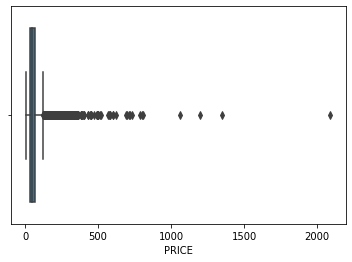

In [110]:
sns.boxplot(x=df_work['PRICE'])

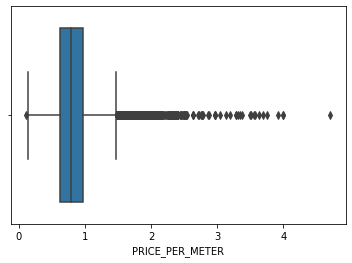

In [111]:
sns.boxplot(x=df_work['PRICE_PER_METER'])

In [112]:
df_work = df_work[df_work['PRICE']<3000]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


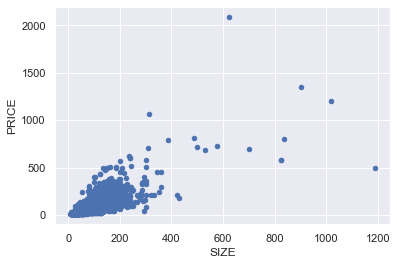

In [186]:
df_work.plot.scatter(x='SIZE', y='PRICE');

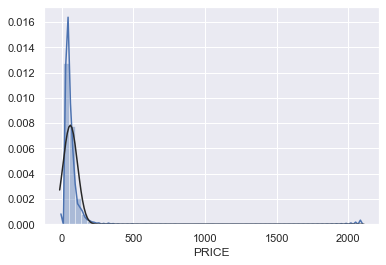

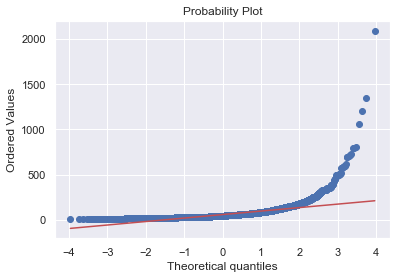

In [138]:
#histogram and normal probability plot
sns.distplot(df_work['PRICE'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_work['PRICE'], plot=plt)

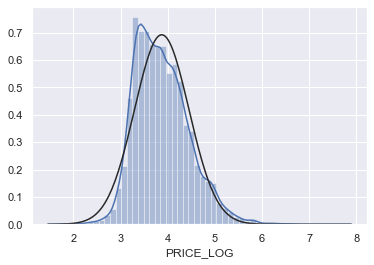

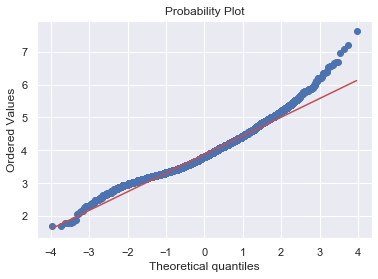

In [143]:
# reducing skewness 

df_work['PRICE_LOG'] = np.log(df_work['PRICE'])

#histogram and normal probability plot
sns.distplot(df_work['PRICE_LOG'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_work['PRICE_LOG'], plot=plt)

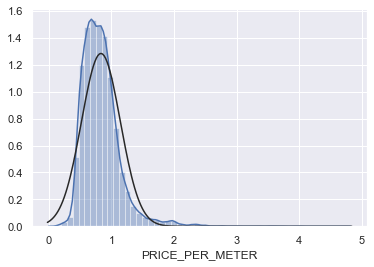

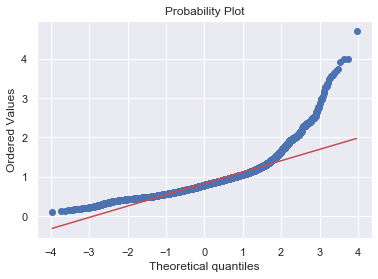

In [139]:
#histogram and normal probability plot
sns.distplot(df_work['PRICE_PER_METER'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_work['PRICE_PER_METER'], plot=plt)

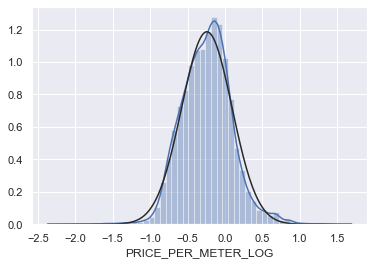

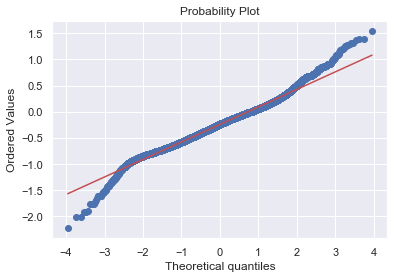

In [145]:
df_work['PRICE_PER_METER_LOG'] = np.log(df_work['PRICE_PER_METER'])

#histogram and normal probability plot
sns.distplot(df_work['PRICE_PER_METER_LOG'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_work['PRICE_PER_METER_LOG'], plot=plt)

In [115]:
df_work = df_work[df_work['ID']!='31087012']

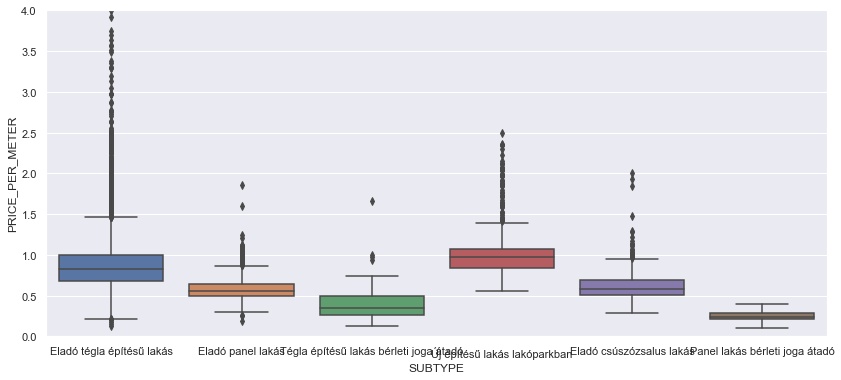

In [152]:
f, ax = plt.subplots(figsize=(14, 6))
fig = sns.boxplot(x='SUBTYPE', y="PRICE_PER_METER", data=df_work)
fig.axis(ymin=0, ymax=4);

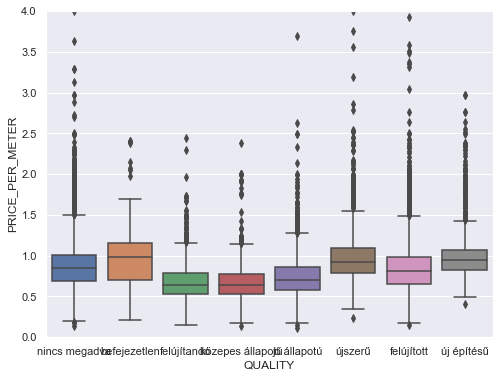

In [153]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='QUALITY', y="PRICE_PER_METER", data=df_work, order=qualities)
fig.axis(ymin=0, ymax=4);

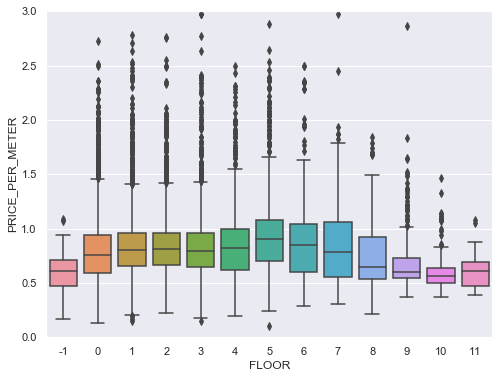

In [154]:
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='FLOOR', y="PRICE_PER_METER", data=df_work)
fig.axis(ymin=0, ymax=3);

(-0.5, 17.5, 0, 3)

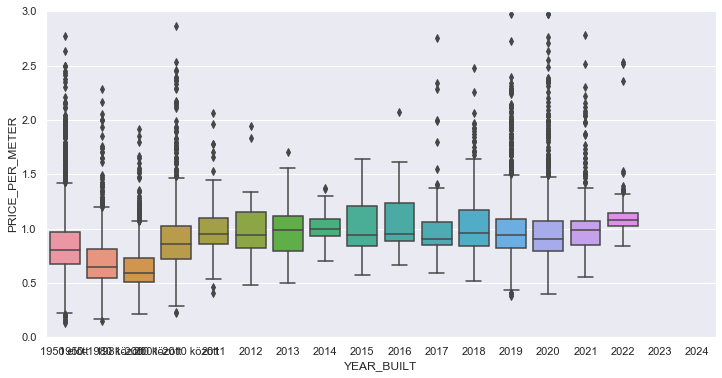

In [155]:
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x='YEAR_BUILT', y="PRICE_PER_METER", data=df_work, order=years)
fig.axis(ymin=0, ymax=3)

(-0.5, 8.5, 0, 3)

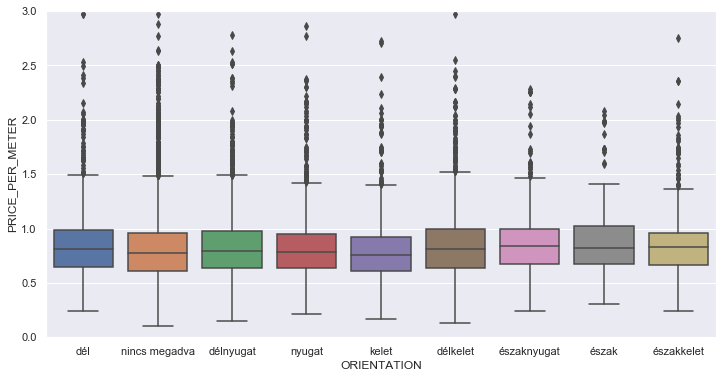

In [156]:
f, ax = plt.subplots(figsize=(12, 6))
fig = sns.boxplot(x='ORIENTATION', y="PRICE_PER_METER", data=df_work)
fig.axis(ymin=0, ymax=3)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


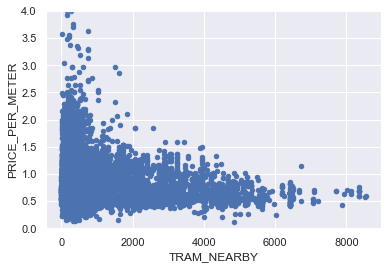

In [157]:

df_work.plot.scatter(x='TRAM_NEARBY', y='PRICE_PER_METER', ylim=(0,4));

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


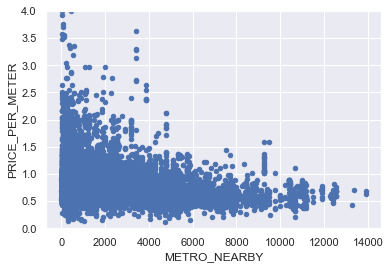

In [158]:
df_work.plot.scatter(x='METRO_NEARBY', y='PRICE_PER_METER', ylim=(0,4));

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


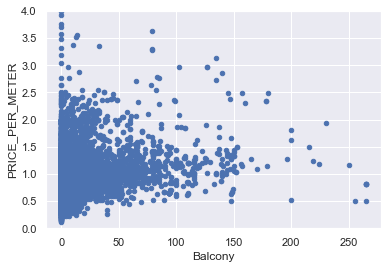

In [179]:
df_work.plot.scatter(x='Balcony', y='PRICE_PER_METER', ylim=(0,4));

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


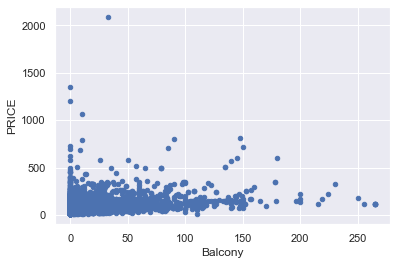

In [185]:
df_work.plot.scatter(x='Balcony', y='PRICE');

In [183]:
df_work[(df_work['Balcony']>100) & (df_work['PRICE_PER_METER']<0.7)]

,ID,SIZE,PRICE,ROOMS,FLOOR,ADDRESS,QUALITY,YEAR_BUILT,FLOORS_IN_BUILDING,LIFT,...,LATITUDE,LONGITUDE,SUBTYPE,DESCRIPTION,rooms,half_rooms,PRICE_PER_METER,TRAM_NEARBY,PRICE_LOG,PRICE_PER_METER_LOG
222,26545158,140,94.4,4,5,"10. kerület, Mélytó Lakópark 3",új építésű,2018,5,van,...,47.482405,19.158975,Új építésű lakás lakóparkban,Eladó ingatlanok Kőbánya legszebb részén a Mé...,4,0,0.674286,38.273211,4.547541,-0.394101
294,26929438,265,139.0,5,3,"11. kerület, Hosszúrét",újszerű,NaN,3,nincs,...,47.466102,18.997380,Eladó tégla építésű lakás,Igazi ritkaság! 11. kerület Madárhegyi részén...,5,0,0.524528,1736.420548,4.934474,-0.645256
479,27612877,277,170.0,4,2,"3. kerület, Csillaghegy",újszerű,2001-2010 között,2,nincs,...,47.586163,19.050705,Eladó tégla építésű lakás,"ELADÓ III. ker. Pünkösdfürdőn, a Duna-parton ...",4,0,0.613718,3952.125665,5.135798,-0.488219
2554,29504285,140,88.7,4,5,"10. kerület, Keresztúridűlő",nincs megadva,2019,5,van,...,47.474090,19.186396,Eladó tégla építésű lakás,HATALMAS TERASZ A LEGFELSŐ EMELETEN !!! AZ ÁR...,4,0,0.633571,626.035591,4.485260,-0.456383
2990,29682893,80,52.0,3,0,"18. kerület, Bókaytelep",befejezetlen,NaN,2,nincs,...,47.438422,19.180897,Eladó tégla építésű lakás,Eladó a 18. kerület Bókay telepen újonnan épü...,3,0,0.650000,400.553822,3.951244,-0.430783
5105,30279785,226,113.0,5,5,"10. kerület, Kőbánya – Újhegy",nincs megadva,2019,5,van,...,47.468380,19.166084,Eladó tégla építésű lakás,"Fantasztikus panoráma a nappaliból, konyhából...",5,0,0.500000,722.482834,4.727388,-0.693147
9864,30873934,137,95.0,4,1,"14. kerület, Herminamező",újszerű,1981-2000 között,3,nincs,...,47.518684,19.099723,Eladó tégla építésű lakás,"ELADÓ 14. KERÜLET I. EMELET, NAPPALI+3 HÁLÓ, ...",4,0,0.693431,201.174603,4.553877,-0.366104
12643,31077430,189,94.3,4,5,"10. kerület, Kőbánya – Újhegy",nincs megadva,2020,5,van,...,47.468380,19.166084,Eladó tégla építésű lakás,A megújuló Kőbányán egy 5 szintes liftes épül...,4,0,0.498942,722.482834,4.546481,-0.695266
12646,31077529,226,113.0,5,5,"10. kerület, Kőbánya – Újhegy",nincs megadva,2020,5,van,...,47.468380,19.166084,Eladó tégla építésű lakás,A megújuló Kőbányán egy 5 szintes liftes épül...,5,0,0.500000,722.482834,4.727388,-0.693147
17325,31321984,23,14.7,1,0,"20. kerület, Nagy Győry István utca",felújított,NaN,nincs megadva,nincs megadva,...,47.435637,19.101700,Eladó tégla építésű lakás,"XX. kerület központjában, mégis nagyon csende...",1,0,0.639130,401.289292,2.687847,-0.447647


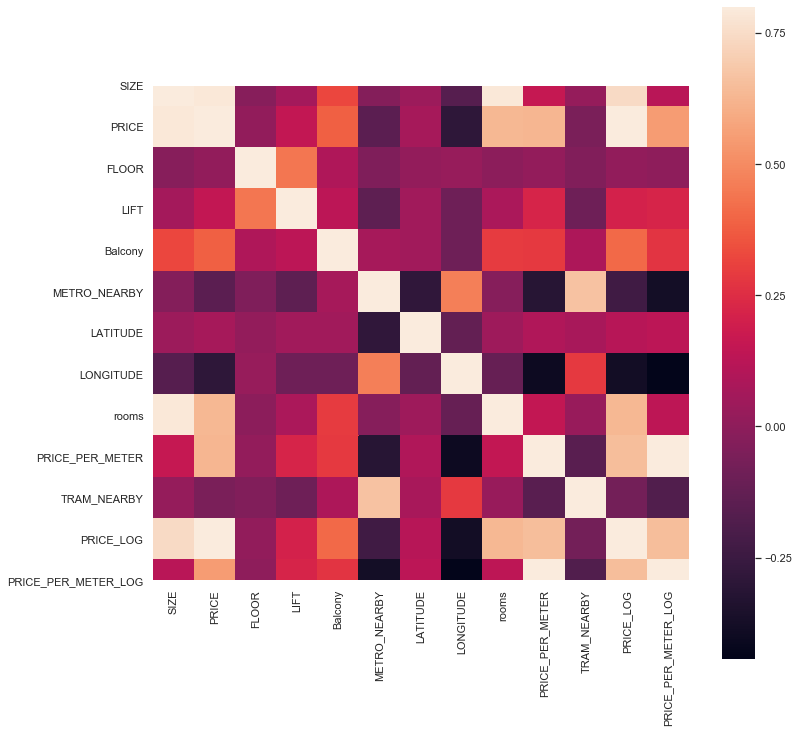

In [195]:
#correlation matrix
corrmat = df_work.corr()
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corrmat, vmax=.8, square=True);

# NLP

In [43]:
from stop_words import get_stop_words
from nltk.stem import *
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
#nltk.download('punkt')
stop_words = get_stop_words('hu')

In [44]:
stemmer = SnowballStemmer("hungarian")

In [47]:
def isStopWord(word):
    return (word in stop_words) or (word.isdigit()) or (not word.isalpha())

In [48]:
wordsAll = df_work["DESCRIPTION"].apply(lambda row : " ".join([stemmer.stem(w) for w in word_tokenize(row) if not isStopWord(w)]))

In [22]:
#wordsExpensive =df_work[df_work['PRICE_PER_METER']>3]["DESCRIPTION"].apply(lambda row : " ".join([stemmer.stem(w) for w in word_tokenize(row)]))

https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.XrR-VKgzaiM

https://kavita-ganesan.com/extracting-keywords-from-text-tfidf/#.XrSHC6gzaiM

https://www.storybench.org/using-french-wine-reviews-understand-tf-idf-measure-unique-word-document/

In [24]:
tfidf_vectorizer=TfidfVectorizer(use_idf=True)
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(wordsAll)
# get the first vector out (for the first document)
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[7]
 
# place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False).head(20)

,tfidf
víg,0.198335
értékesítés,0.166617
jogerős,0.155830
lakás,0.138176
gazdaságos,0.128511
az,0.126621
engedély,0.122697
erőből,0.119219
házias,0.119219
kollégánkat,0.119219


In [62]:
vectorizer = TfidfVectorizer()
vectors =vectorizer.fit_transform(wordsAll)
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df_desc = pd.DataFrame(denselist, columns=feature_names)

In [63]:
df_desc

,aa,aaa,ab,abbamar,abbáz,abc,abcáruház,abelvár,abelváros,aber,...,房间,接近马加什教堂,普通ktg,暖气和热水,理工大学,该地区拥有operet,距离mechwar,酒店已经过装修为了满足所有需求从审美和技术的角度来看,里公寓,顶层
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18554,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
X = df_desc
y = df_work['PRICE_PER_METER']

In [35]:
from sklearn import linear_model

In [36]:
lm = linear_model.LinearRegression()
model = lm.fit(X,y)

In [39]:
lst = list(zip(X.columns, lm.coef_))
sorted(lst, key=lambda tup: -tup[1])

[('12pontos', 64716698293886.45),
 ('160e', 51355488534558.76),
 ('1160', 48936129983351.15),
 ('5m²fürdő', 47937848426215.64),
 ('entré', 46930452404701.81),
 ('067nyíl', 38198174537683.586),
 ('1150', 36612310078435.766),
 ('072befektető', 36068176970239.19),
 ('1832', 33037908429154.297),
 ('2a', 30449721948997.418),
 ('110000', 30252740414405.76),
 ('1900s', 29429355072310.7),
 ('039', 28771997732407.707),
 ('062eladó', 28559713571651.27),
 ('026', 27736958352332.105),
 ('070ft', 25578661994925.457),
 ('18eft', 24071496924135.48),
 ('11nmkonyh', 23766511349476.97),
 ('000forin', 23189827461034.227),
 ('09nm', 22630281735909.223),
 ('168nm', 21916353608450.723),
 ('projektünkből', 21627971969828.242),
 ('felhí', 20825956992327.7),
 ('készítésü', 20739007391833.03),
 ('syko', 20739007391833.03),
 ('tömegközlegedeés', 20739007391833.03),
 ('fütésről', 20731922608594.996),
 ('felújítottunk', 20610932199768.363),
 ('0395eladó', 20603045863029.613),
 ('126a', 20491985826664.07),
 ('elsze

In [144]:
cv=CountVectorizer()
word_count_all=cv.fit_transform(word.lower() for word in wordsAll if  not isStopWord(word.lower()))

In [145]:
cv2=CountVectorizer()
word_count_expensive=cv2.fit_transform(word.lower() for word in wordsExpensive if  not isStopWord(word.lower()))

In [146]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_all)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [147]:
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"])

In [148]:
df_idf.sort_values(by=['idf_weights'])

,idf_weights
lakás,5.027919
is,5.036915
található,6.073490
ingatlan,6.103441
eladó,6.122937
...,...
korszerûsítése,14.723552
korszerüsíteni,14.723552
korszerüsítést,14.723552
kornyezo,14.723552


In [150]:
word_count_expensive=cv.fit_transform(word.lower() for word in wordsExpensive if  not isStopWord(word.lower()))
tf_idf_vector=tfidf_transformer.transform(word_count_expensive)

ValueError: Input has n_features=31796 while the model has been trained with n_features=70170

In [134]:

feature_names = cv.get_feature_names()
 
#get tfidf vector for first document
first_document_vector=tf_idf_vector[0]
 
#print the scores
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
belváros,1.0
percnél,0.0
perfect,0.0
peres,0.0
peremű,0.0
...,...
hordetnem,0.0
hopp,0.0
hope,0.0
hoover,0.0


In [112]:
from collections import Counter
Counter(word.lower() for word in words if  not isStopWord(word.lower())).most_common(200)

[('is', 6718),
 ('lakás', 6552),
 ('the', 2617),
 ('található', 2303),
 ('lakások', 2092),
 ('ingatlan', 2032),
 ('eladó', 1814),
 ('kiváló', 1648),
 ('nm', 1640),
 ('m2', 1607),
 ('belső', 1485),
 ('ház', 1437),
 ('nappali', 1295),
 ('épület', 1285),
 ('akár', 1238),
 ('szobás', 1237),
 ('két', 1228),
 ('and', 1228),
 ('külön', 1184),
 ('társasház', 1125),
 ('budapest', 1112),
 ('csendes', 1081),
 ('felújított', 1069),
 ('terasz', 1067),
 ('közös', 1039),
 ('emeleti', 1038),
 ('egyedi', 1016),
 ('lakást', 989),
 ('szoba', 959),
 ('perc', 932),
 ('kerület', 922),
 ('tároló', 919),
 ('elérhető', 919),
 ('köszönhetően', 915),
 ('modern', 914),
 ('konyha', 914),
 ('műszaki', 913),
 ('magas', 912),
 ('fürdőszoba', 894),
 ('of', 892),
 ('lakáshoz', 886),
 ('tartozik', 880),
 ('utca', 856),
 ('lehetőség', 854),
 ('beépített', 848),
 ('tágas', 805),
 ('utcában', 795),
 ('világos', 753),
 ('in', 749),
 ('első', 742),
 ('db', 741),
 ('lakásos', 723),
 ('rendelkező', 718),
 ('lakópark', 709),
 (

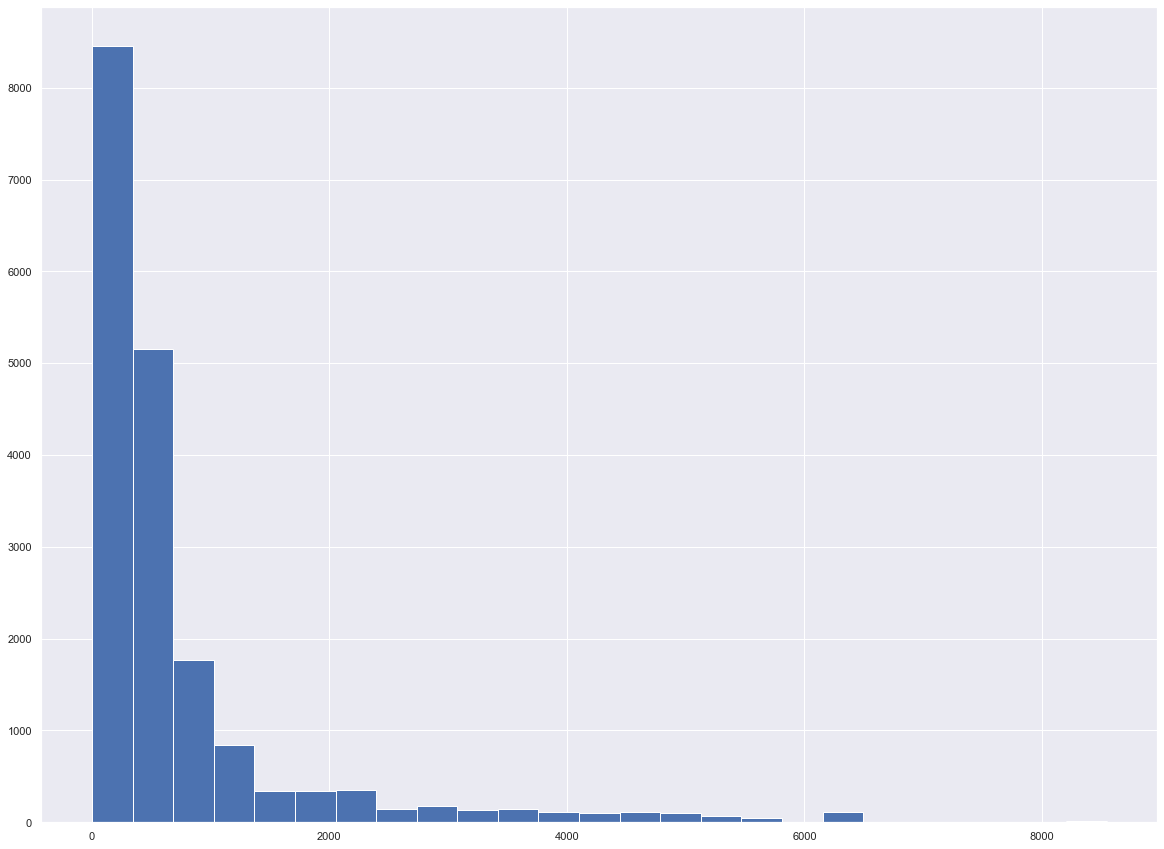

In [199]:
df_work['TRAM_NEARBY'].hist(bins=25, figsize=(20,15))

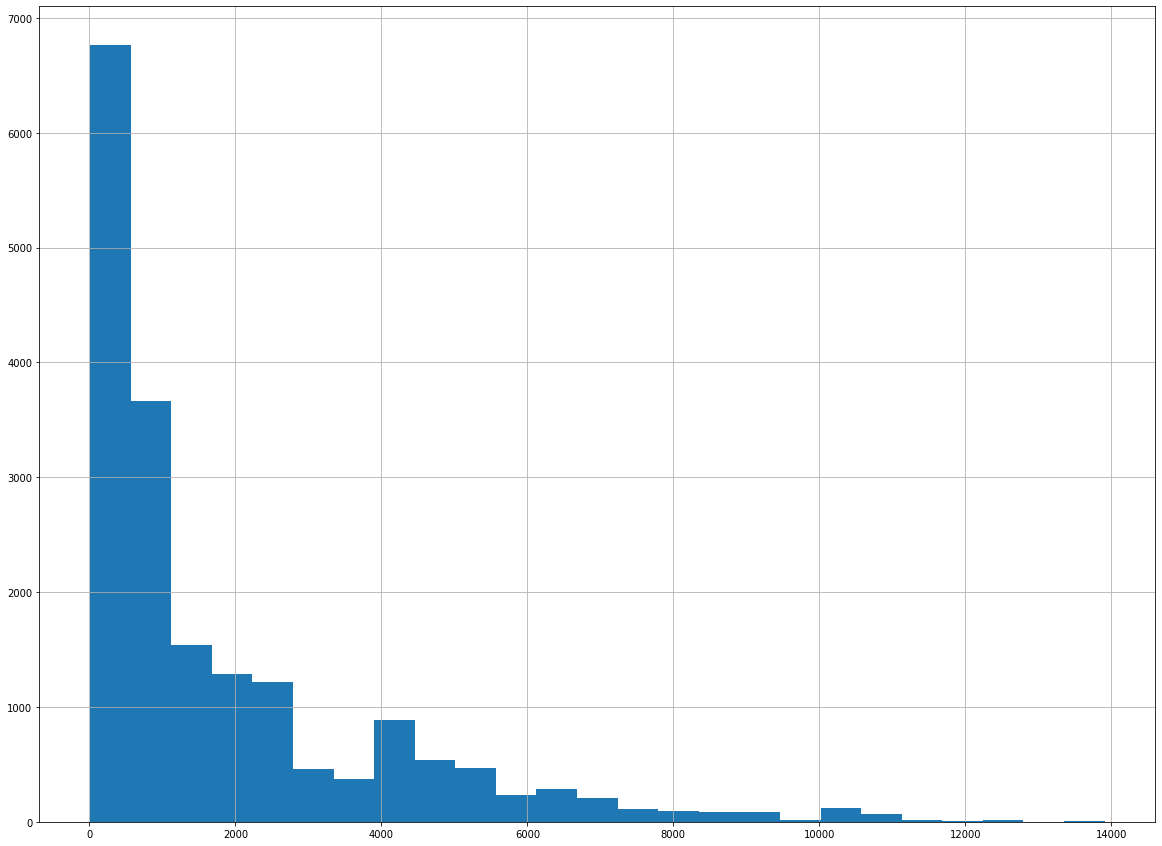

In [64]:
df_work['METRO_NEARBY'].hist(bins=25, figsize=(20,15))

In [201]:
df_work['PRICE_PER_METER'] = df_work['PRICE_PER_METER'].astype('float')

In [ ]:
df_work[df_work['SUBTYPE'] == 'Eladó tégla építésű lakás'].groupby(['DISTRICT', 'TRAM_NEARBY']).mean().reset_index()

In [ ]:
df_work[df_work['SUBTYPE'] == 'Eladó tégla építésű lakás'].groupby(['ADDRESS']).mean().reset_index().sort_values(by=['PRICE_PER_METER'], ascending=False)

In [ ]:
df_work[df_work['ADDRESS'] == '1. kerület, Tárnok utca']

In [ ]:
df_district

### from https://github.com/integralvision/geo-data-hungary/tree/master/GeoJSON

In [206]:
df_district = df_work.groupby(['DISTRICT']).mean().reset_index()

In [207]:
df_district['DISTRICT'] = df_district['DISTRICT'].str.zfill(3)

In [208]:
#geojson.GeoJSON(open('./data/GeoJSON/l40-district/001-budapest-01-kerulet.geojson').read())
geojson = folium.GeoJson(data=(open("./data/budapest.geojson", "r")).read())

In [209]:
json = geojson.data

In [210]:

# create a map
m = folium.Map(location=[np.median(df_work['LATITUDE'].tolist()),
                         np.median(df_work['LONGITUDE'].tolist())],
               tiles='Stamen Toner', zoom_start=12)

## add chloropleth layer
m.choropleth(
    geo_data=json,
    name='Average price',
    data=df_district,
    columns=['DISTRICT', 'PRICE_PER_METER'],
    fill_color='YlGn',
    key_on='feature.properties.ksh',
    legend_name='inc_tax_per_capita'
)  

# add markers with basic information
'''
fg = folium.FeatureGroup(name='District Info')
for lat, lon, val, name in zip(gdf_income_tax['centroid_lat'].tolist(),
                               gdf_income_tax['centroid_lon'].tolist(),
                               gdf_income_tax['inc_tax_per_capita'].tolist(),
                               gdf_income_tax['name'].tolist()):
    html = f"""
    <h2>{name}<\h2><br>
    <h4>Income Tax Per Capita: {int(round(val,0))} HUF <\h4>
    """
    fg.add_child(folium.Marker(location=[lat, lon], popup=html))

m.add_child(fg)

# enable layers to be turned in or out
'''

C:\Developer\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


'\nfg = folium.FeatureGroup(name=\'District Info\')\nfor lat, lon, val, name in zip(gdf_income_tax[\'centroid_lat\'].tolist(),\n                               gdf_income_tax[\'centroid_lon\'].tolist(),\n                               gdf_income_tax[\'inc_tax_per_capita\'].tolist(),\n                               gdf_income_tax[\'name\'].tolist()):\n    html = f"""\n    <h2>{name}<\\h2><br>\n    <h4>Income Tax Per Capita: {int(round(val,0))} HUF <\\h4>\n    """\n    fg.add_child(folium.Marker(location=[lat, lon], popup=html))\n\nm.add_child(fg)\n\n# enable layers to be turned in or out\n'

In [211]:
folium.LayerControl().add_to(m)

In [212]:
type(m)

folium.folium.Map

In [213]:
display(m)

In [229]:
from folium import plugins
heatmap = folium.Map(location=[np.median(df_work['LATITUDE'].tolist()),
                         np.median(df_work['LONGITUDE'].tolist())], zoom_start=14)
arr1 = metro_coord[['stop_lat', 'stop_lon']].values.tolist()
heatmap.add_child(plugins.HeatMap(arr1, radius=15, gradient={.4: 'blue', .65: 'blue', 1: 'blue'}))

arr1 = tram_coord[['stop_lat', 'stop_lon']].values.tolist()
heatmap.add_child(plugins.HeatMap(arr1, radius=10, gradient={.4: 'yellow', .65: 'yellow', 1: 'yellow'}))



In [234]:
from folium import plugins
heatmap = folium.Map(location=[np.median(df_work['LATITUDE'].tolist()),
                         np.median(df_work['LONGITUDE'].tolist())], zoom_start=14)
arr1 = df_work[df_work['SUBTYPE'] == 'Új építésű lakás lakóparkban'][['LATITUDE', 'LONGITUDE', 'PRICE_PER_METER']].values.tolist()
heatmap.add_child(plugins.HeatMap(arr1, radius=15))

In [215]:
from folium import plugins
heatmap = folium.Map(location=[np.median(df_work['LATITUDE'].tolist()),
                         np.median(df_work['LONGITUDE'].tolist())], zoom_start=14)
arr1 = df_work[df_work['SUBTYPE'] == 'Eladó tégla építésű lakás'][['LATITUDE', 'LONGITUDE', 'PRICE_PER_METER']].values.tolist()
heatmap.add_child(plugins.HeatMap(arr1, radius=15))

# Building the Model

In [574]:
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

In [575]:
X.dtypes

SIZE                     int32
ROOMS                   object
FLOOR                    int32
ADDRESS                 object
QUALITY                   int8
YEAR_BUILT                int8
FLOORS_IN_BUILDING        int8
LIFT                      bool
Balcony                float64
ORIENTATION             object
VIEW                  category
METRO_NEARBY           float64
PARKING                 object
DISTRICT                object
SUBTYPE               category
DESCRIPTION             object
rooms                    int32
half_rooms              object
TRAM_NEARBY            float64
dél                      uint8
délkelet                 uint8
délnyugat                uint8
kelet                    uint8
nincs megadva            uint8
nyugat                   uint8
észak                    uint8
északkelet               uint8
északnyugat              uint8
dtype: object

In [576]:
train_df = df_work[df_work['SUBTYPE'].isin(['Eladó tégla építésű lakás'])]
X, y = train_df.drop(['ID','PRICE','PRICE_LOG','PRICE_PER_METER', 'PRICE_PER_METER_LOG', 'LATITUDE', 'LONGITUDE'],axis=1), train_df['PRICE']
X['QUALITY'] = X['QUALITY'].cat.codes
X['YEAR_BUILT'] = X['YEAR_BUILT'].cat.codes
X['FLOORS_IN_BUILDING'] = X['FLOORS_IN_BUILDING'].cat.codes
dummy_orientation = pd.get_dummies(X['ORIENTATION'])
X = X.join(dummy_orientation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)



In [577]:
X_train.loc[:,selected_columns_1]

,SIZE,FLOOR,DISTRICT,METRO_NEARBY,TRAM_NEARBY,QUALITY,YEAR_BUILT,FLOORS_IN_BUILDING,dél,délkelet,délnyugat,kelet,nincs megadva,nyugat,észak,északkelet,északnyugat
16266,74,0,9,580.384536,4.723547,0,-1,0,0,0,0,0,1,0,0,0,0
17744,34,0,16,2819.417205,2562.197196,0,-1,0,0,0,0,0,1,0,0,0,0
12275,44,0,22,5707.493481,1427.946762,4,0,1,0,0,0,0,0,1,0,0,0
10099,35,1,8,859.641033,369.947560,3,0,4,0,0,1,0,0,0,0,0,0
10448,41,1,13,307.747665,508.662410,3,-1,2,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411,162,1,5,400.644094,351.013346,0,-1,0,0,0,0,0,1,0,0,0,0
6871,39,3,9,2830.948740,266.751516,4,-1,3,0,0,0,1,0,0,0,0,0
11970,34,0,7,382.929817,543.668426,2,0,0,0,1,0,0,0,0,0,0,0
13842,122,1,6,109.633379,168.451658,2,0,4,0,0,0,0,0,0,0,1,0


In [578]:
selected_columns_1 = ['SIZE', 'FLOOR', 'DISTRICT', 'METRO_NEARBY', 'TRAM_NEARBY', 'QUALITY', 'YEAR_BUILT', 'FLOORS_IN_BUILDING'] + dummy_orientation.columns.tolist()
# Applying scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.loc[:,selected_columns_1])
X_test_scaled = scaler.transform(X_test.loc[:,selected_columns_1])

lr_baseline = LinearRegression()
lr_baseline.fit(X_train_scaled,y_train)
lr_baseline.coef_, lr_baseline.intercept_

(array([43.90684794,  2.45192768, -6.67613093, -2.3160793 , -1.28780081,
         2.32012511,  6.60448798, -0.37973859, -0.30823759, -0.10099819,
        -0.41642078, -0.48398308,  0.82898032,  0.27799536,  0.22535589,
        -0.44044751, -0.16409358]), 64.24044285714285)

In [579]:
model = MLPRegressor(hidden_layer_sizes=(10,5))
model.fit(X_train_scaled,y_train)

C:\Developer\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(10, 5), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [580]:
# Get the predictions on the test set
test_set_pred1 = lr_baseline.predict(X_test.loc[:,selected_columns_1])

In [581]:
np.sqrt(mean_squared_error(y_test, test_set_pred1)), mean_absolute_error(y_test,test_set_pred1)

(5754.562792011265, 3417.4775186519764)

In [582]:
print('Baseline regression test R^2:', lr_baseline.score(X_test_scaled, y_test))

Baseline regression test R^2: 0.6203056474353059


In [583]:
print('Baseline mlp test R^2:', model.score(X_test_scaled, y_test))

Baseline mlp test R^2: 0.6498578314351171


# Results

In [ ]:
We can see that unsurprisingly the most importan feature for price is size. It is also important what is the floor

In [584]:
lst = list(zip(X.columns, lr_baseline.coef_))
sorted(lst, key=lambda tup: -tup[1])

[('SIZE', 43.90684794499332),
 ('FLOORS_IN_BUILDING', 6.604487984671434),
 ('ROOMS', 2.451927682335346),
 ('YEAR_BUILT', 2.3201251116786255),
 ('PARKING', 0.8289803201573892),
 ('DISTRICT', 0.2779953609323246),
 ('SUBTYPE', 0.22535589199658757),
 ('ORIENTATION', -0.10099819413856148),
 ('rooms', -0.16409357716392714),
 ('Balcony', -0.30823758512177113),
 ('LIFT', -0.3797385868044629),
 ('VIEW', -0.4164207761808507),
 ('DESCRIPTION', -0.440447514662035),
 ('METRO_NEARBY', -0.4839830839416324),
 ('QUALITY', -1.2878008064275899),
 ('ADDRESS', -2.316079297655916),
 ('FLOOR', -6.676130930405664)]